In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# --- 1. CONFIGURATION ---
# Path where you saved the train/val/test CSVs
DATA_DIR = r"E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Data\Multimodal"
MODELS_DIR = r"E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Models"

# Model Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15  # You can increase this if accuracy is still improving
LEARNING_RATE = 0.0001

# Ensure model directory exists
os.makedirs(MODELS_DIR, exist_ok=True)

print("Configuration Set.")
print(f"TensorFlow Version: {tf.__version__}")

Configuration Set.
TensorFlow Version: 2.20.0


In [3]:
# --- 2. LOAD DATA ---
print("\nLoading Datasets...")
train_df = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
val_df = pd.read_csv(os.path.join(DATA_DIR, "val_data.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test_data.csv"))

print(f"Train Shape: {train_df.shape}")
print(f"Val Shape:   {val_df.shape}")
print(f"Test Shape:  {test_df.shape}")


Loading Datasets...
Train Shape: (2555, 75)
Val Shape:   (547, 75)
Test Shape:  (548, 75)


In [4]:
# --- 3. PREPROCESSING CLINICAL DATA ---
print("\nPreprocessing Clinical Features...")

# Define columns to exclude from features (Target, Paths, IDs if any remain)
non_feature_cols = ['target', 'image_path', 'person_neoplasm_cancer_status']
feature_cols = [c for c in train_df.columns if c not in non_feature_cols]

# 1. Handle Categorical Data (One-Hot Encoding)
# We combine them temporarily to ensure columns match, then split back
combined_df = pd.concat([train_df[feature_cols], val_df[feature_cols], test_df[feature_cols]], axis=0)
combined_dummies = pd.get_dummies(combined_df, drop_first=True)

# Split back into sets
train_clin_raw = combined_dummies.iloc[:len(train_df)]
val_clin_raw = combined_dummies.iloc[len(train_df):len(train_df)+len(val_df)]
test_clin_raw = combined_dummies.iloc[len(train_df)+len(val_df):]

# 2. Scale Data (StandardScaler)
# IMPORTANT: Fit ONLY on training data to prevent leakage
scaler = StandardScaler()
X_train_clin = scaler.fit_transform(train_clin_raw)
X_val_clin = scaler.transform(val_clin_raw)
X_test_clin = scaler.transform(test_clin_raw)

# Get Targets and Image Paths
y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

train_img_paths = train_df['image_path'].values
val_img_paths = val_df['image_path'].values
test_img_paths = test_df['image_path'].values

print(f"Clinical Features after processing: {X_train_clin.shape[1]}")


Preprocessing Clinical Features...
Clinical Features after processing: 218


In [5]:
# --- 4. CREATE TENSORFLOW DATA PIPELINE ---

def process_image(path):
    """Reads an image, decodes JPEG, resizes, and applies EfficientNet preprocessing."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = applications.efficientnet.preprocess_input(img)
    return img

def create_dataset(clinical_data, image_paths, labels, shuffle=False):
    """Creates a tf.data.Dataset yielding ((clinical, image), label)."""

    # Create tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((
        clinical_data,
        image_paths,
        labels
    ))

    # Map function to load image
    def map_func(clin, img_path, label):
        img = process_image(img_path)
        return (clin, img), label

    # Apply map
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

print("\nCreating Data Loaders...")
train_ds = create_dataset(X_train_clin, train_img_paths, y_train, shuffle=True)
val_ds = create_dataset(X_val_clin, val_img_paths, y_val, shuffle=False)
test_ds = create_dataset(X_test_clin, test_img_paths, y_test, shuffle=False)
print("Data Loaders Ready.")


Creating Data Loaders...
Data Loaders Ready.


In [6]:
# --- 5. BUILD MULTIMODAL MODEL ---
print("\nBuilding Model Architecture...")

# Branch 1: Clinical (Dense Network)
clinical_input = layers.Input(shape=(X_train_clin.shape[1],), name="clinical_input")
x_clin = layers.Dense(64, activation="relu")(clinical_input)
x_clin = layers.BatchNormalization()(x_clin)
x_clin = layers.Dropout(0.3)(x_clin)
x_clin = layers.Dense(32, activation="relu")(x_clin)

# Branch 2: Imaging (EfficientNetB0)
image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")
base_cnn = applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=image_input
)
base_cnn.trainable = False # Freeze the CNN weights

x_img = base_cnn.output
x_img = layers.GlobalAveragePooling2D()(x_img)
x_img = layers.Dropout(0.3)(x_img)

# Feature Fusion (Concatenation)
fused = layers.Concatenate(name="fusion_layer")([x_clin, x_img])

# Classification Head
x = layers.Dense(128, activation="relu")(fused)
x = layers.Dropout(0.4)(x)
output = layers.Dense(1, activation="sigmoid", name="cancer_prediction")(x)

# Create final model
model = models.Model(inputs=[clinical_input, image_input], outputs=output, name="Multimodal_Fusion_Model")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()


Building Model Architecture...


Model: "Multimodal_Fusion_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,234,116 (16.15 MB)

 Trainable params: 184,417 (720.38 KB)

 Non-trainable params: 4,049,699 (15.45 MB)

In [7]:
# --- 6. TRAIN MODEL ---
print("\nStarting Training...")

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Starting Training...
Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 89s 854ms/step - accuracy: 0.8626 - auc: 0.9437 - loss: 0.3367 - val_accuracy: 0.9835 - val_auc: 0.9978 - val_loss: 0.1164 - learning_rate: 1.0000e-04
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 843ms/step - accuracy: 0.9683 - auc: 0.9964 - loss: 0.1108 - val_accuracy: 0.9909 - val_auc: 0.9987 - val_loss: 0.0618 - learning_rate: 1.0000e-04
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 846ms/step - accuracy: 0.9781 - auc: 0.9982 - loss: 0.0717 - val_accuracy: 0.9927 - val_auc: 0.9991 - val_loss: 0.0433 - learning_rate: 1.0000e-04
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 845ms/step - accuracy: 0.9843 - auc: 0.9988 - loss: 0.0545 - val_accuracy: 0.9945 - val_auc: 0.9994 - val_loss: 0.0334 - learning_rate: 1.0000e-04
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 72s 870ms/step - accuracy: 0.9867 - auc: 0.9991 - loss: 0.0442 - val_accuracy: 0.9945 - val_auc: 0.9996 - val_loss: 0.0275 - learning_rate: 1.0000e-04
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━


Running Final Evaluation on Test Set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 668ms/step - accuracy: 0.9964 - auc: 0.9999 - loss: 0.0135
Test Accuracy: 99.64%
Test AUC:      0.9999
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 750ms/step


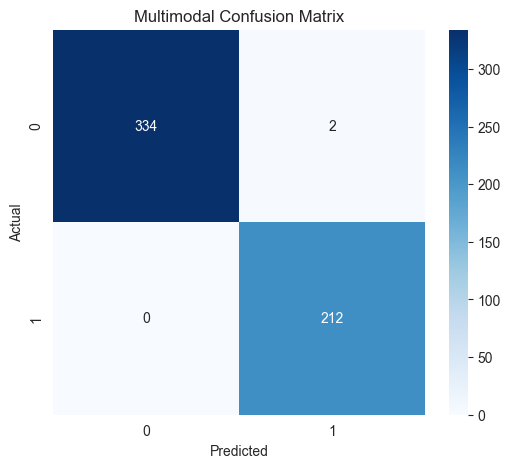


Classification Report:
              precision    recall  f1-score   support

  Tumor Free       1.00      0.99      1.00       336
  With Tumor       0.99      1.00      1.00       212

    accuracy                           1.00       548
   macro avg       1.00      1.00      1.00       548
weighted avg       1.00      1.00      1.00       548



In [8]:
# --- 7. EVALUATE ---
print("\nRunning Final Evaluation on Test Set...")
results = model.evaluate(test_ds)
print(f"Test Accuracy: {results[1] * 100:.2f}%")
print(f"Test AUC:      {results[2]:.4f}")

# Confusion Matrix & Report
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Multimodal Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
target_names = ['Tumor Free', 'With Tumor']
print(classification_report(y_test, y_pred, target_names=target_names))

In [11]:
import pandas as pd
import numpy as np

# --- 1. GATHER PREDICTIONS ---
# We assume model.predict() has already been run in the previous step
# y_pred_probs = model.predict(test_ds, verbose=0).flatten()
# y_pred = (y_pred_probs > 0.5).astype(int)

# Get image filenames for reference (just the name, not full path)
filenames = [os.path.basename(f) for f in test_df['image_path'].values]

# Identify indices
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

# --- 2. BUILD THE TABLE DATA ---
table_data = []

# Helper function to add rows
def add_to_table(indices, status, limit):
    count = 0
    for idx in indices:
        if count >= limit: break

        # Calculate confidence (distance from 0.5)
        # If prob is 0.9, confidence is 90% for class 1
        # If prob is 0.1, confidence is 90% for class 0
        prob = y_pred_probs[idx]
        confidence = prob if y_pred[idx] == 1 else 1 - prob

        table_data.append({
            "Status": status,
            "Image File": filenames[idx],
            "Actual": class_names[y_true[idx]],
            "Predicted": class_names[y_pred[idx]],
            "Confidence": f"{confidence:.2%}"
        })
        count += 1

# Add 10 Correct
add_to_table(correct_indices, "✅ Correct", 10)

# Add 5 Incorrect
add_to_table(incorrect_indices, "❌ Incorrect", 5)

# --- 3. DISPLAY TABLE ---
results_df = pd.DataFrame(table_data)

# Optional: Style the table if running in Jupyter
def highlight_status(s):
    return ['background-color: #d4edda' if v == '✅ Correct' else 'background-color: #f8d7da' for v in s]

print(f"\nTotal Test Samples: {len(test_df)}")
print(f"Correct: {len(correct_indices)}")
print(f"Incorrect: {len(incorrect_indices)}\n")

# Display with color highlighting
try:
    display(results_df.style.apply(highlight_status, subset=['Status']))
except:
    # Fallback if not in Jupyter or styling fails
    print(results_df)


Total Test Samples: 548
Correct: 546
Incorrect: 2



,Status,Image File,Actual,Predicted,Confidence
0,✅ Correct,c5f46088-a8b5-4db8-8e61-51f0f3e2dd18.jpg,Tumor Free,Tumor Free,99.99%
1,✅ Correct,19b70245-0218-4018-a622-a3b87f778ffd.jpg,With Tumor,With Tumor,99.34%
2,✅ Correct,66f7ae10-730b-4d3d-931e-73285d65ef5f.jpg,With Tumor,With Tumor,99.99%
3,✅ Correct,9ebcd399-4725-43d4-8040-a4c4da888e0c.jpg,Tumor Free,Tumor Free,100.00%
4,✅ Correct,3da5cc47-6c2f-4e67-b5b8-3fb1ef7e6426.jpg,Tumor Free,Tumor Free,99.99%
5,✅ Correct,2172ed4d-adb9-4183-9858-7a9a56e91c4b.jpg,Tumor Free,Tumor Free,100.00%
6,✅ Correct,2b2b3c0b-12bf-4081-89fa-774f13ad4396.jpg,Tumor Free,Tumor Free,99.98%
7,✅ Correct,5d1184d7-f8f0-4800-b7c1-4117f773a3ef.jpg,Tumor Free,Tumor Free,100.00%
8,✅ Correct,d3c1a23b-c67d-41eb-969f-4283aa1d2f37.jpg,With Tumor,With Tumor,99.99%
9,✅ Correct,dc31d822-e062-4f78-813e-5f9b9ad2bcf7.jpg,With Tumor,With Tumor,99.97%


In [9]:
# --- 8. SAVE MODEL ---
save_path = os.path.join(MODELS_DIR, "Multimodal_Feature_Fusion_Model.keras")
model.save(save_path)
print(f"\n✅ Model Saved to: {save_path}")


✅ Model Saved to: E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Models\Multimodal_Feature_Fusion_Model.keras
